<h1 align="center">DIP - Lab 2</h2>

<h2>Imports and Stuff</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

def displayImage(images, nrows = 1, ncols=1, title=[],image_max=0,plotsize=10):
    #Handle the case of 1 image
    if nrows == 1 and ncols == 1:
        images = [images]
    #Mismatch
    if len(images) != nrows*ncols:
        print("Number of images != number of subplots")
        return
    #Title mismathc
    if len(images) != len(title) and len(title)!=0:
        print("Number of images != number of titles")
        return
    fig = plt.figure(figsize=(plotsize,plotsize))
    ax = []
    for i in range(1, ncols*nrows +1):
        image = images[i-1]
        
        #Deal for various types
        type = image.dtype
        if np.issubdtype(type, np.integer):
            if image_max==0:
                im_max = np.iinfo(type).max
            else:
                im_max=copy.deepcopy(image_max)
        else:
            im_max = 1
        
        plt.gray()
        ax.append( fig.add_subplot(nrows, ncols,i))
        if len(title)!=0:
            ax[-1].set_title(title[i-1])
        plt.axis("off")
        plt.imshow(image,vmin=0,vmax=im_max)
    plt.show()
    
#Convert float to uint8
def im2int8(image):
    image = image.astype(np.float32)
    image = 255 * image
    image = image.astype(np.uint8)
    return image

#Converts an image to float32
def im2float32(image):
    type = image.dtype
    if np.issubdtype(type, np.integer):
        info = np.iinfo(image.dtype)
        image = image.astype(np.float32) / info.max
    return image

<h2 align="center">Problems</h2>

<b>Question 1:</b> Explain why the discrete histogram equalization technique does not in general yield a flat histogram.
<br>
<br>
The process merely maps pixel values. If more than 1/L pixels have the same value, then they will still have the same value after the process and thus the histogram will not be flat.
<br>
We aren't redistributing intensity levels

<b>Question 2:</b> Take each of the examples in Table 1, with 16 pixels and 3 bit dynamic range monochrome values, and apply a contrast stretch and histogram equalization modification. Comment on the results. What would you say are the
key differences between a contrast stretch and a histogram equalization?

<img src="table1.png">

Displaying table  1


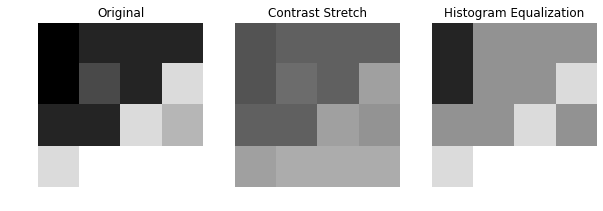

Displaying table  2


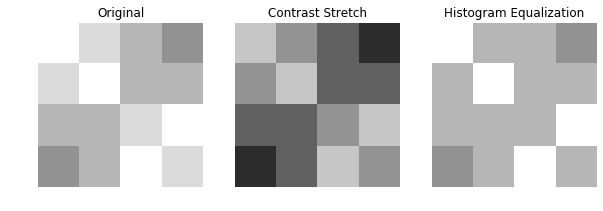

Displaying table  3


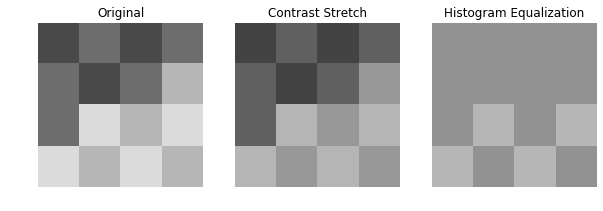

In [2]:
#Initialize Tables
list1 = [[0,1,1,1],[0,2,1,6],[1,1,6,5],[6,7,7,7]]
table1 = np.array(list1)

list2 = [[7,6,5,4],[6,7,5,5],[5,5,6,7],[4,5,7,6]]
table2 = np.array(list2)

list3 = [[2,3,2,3],[3,2,3,5],[3,6,5,6],[6,5,6,5]]
table3 = np.array(list3)

#The piecewise function used to perform the contrast stretch (float32 format)
def contrastStretchFunction(x,pl,ph):
    if x<pl:
        return 0
    elif x>ph:
        return 1
    else:
        return (x-pl)/(ph-pl)
            
#Performs a contrast stretch on a float32 image, taking into account the outliers
def contrastStretch(image):
    q1 = np.percentile(image,25)
    q3 = np.percentile(image,75)
    iqr = q3-q1
    pl = q1-1.5*iqr
    ph = q3+1.5*iqr
    
    for (x,y),value in np.ndenumerate(image):
        image[x,y] = contrastStretchFunction(value,pl,ph)
    return image

#Gets the Histogram of an Image
def getHistogram(image,max):
    histogram,bin_edges = np.histogram(image,max+1)
    
    return histogram

#Gets the probability of each grey level from a histogram
def getProbs(histogram):
    n = sum(histogram)
    probs = histogram/n
    return probs
    
#Get the cumulative probs
def getCumulative(probs):
    return np.cumsum(probs)

#Get new mapping from cumulative distribution
def CDFToMap(cdf,max):
    return np.round(max*cdf)

#Perform Histogram Equalization
def histogramEqualization(image,max):
    histogram = getHistogram(image,max)
    probs = getProbs(histogram)
    cdf = getCumulative(probs)
    myMap = CDFToMap(cdf,max) 
    return applyMap(image,myMap)

#Apply a mapping to an image
def applyMap(image,mapping):
    for (x,y),value in np.ndenumerate(image):
        image[x,y] = mapping[value] 
    return image

#Display the original table as well as a contrast-stetched one and a histogrammed one
def displayTableContrastHistogram(table,number,max):
    print("Displaying table ",number)
    tableC = im2float32(copy.deepcopy(table))
    tableH = copy.deepcopy(table)
    contrasted = contrastStretch(tableC)*7
    displayImage([table,contrastStretch(tableC),histogramEqualization(tableH,max)],1,3, \
                 title=["Original","Contrast Stretch","Histogram Equalization"],image_max=7)


displayTableContrastHistogram(table1,1,7)
displayTableContrastHistogram(table2,2,7)
displayTableContrastHistogram(table3,3,7)

Contrast Stretching takes the existing distribution and "stretches" it across the full dynamic range. Histogram Equalization, on the other hand, attempts to flatten the distribution of the image so that, ideally, any point along the full dynamic range is equally likely to occur in the image.

<b>Question 3:</b> 
<ol>
    <li>What effect would setting to zero the lower-order bit planes have on the histogram of an image in general?
        <ul>
            <li>This would have the effect of removing certain multiples from the histogram. Thus there would be gaps in the histogram, and the remaining components will be bigger.
        </ul>
    <li>What would be the effect on the histogram if we set to zero the higher-order bit planes instead?
        <ul>
            <li>The histogram would shift to the left, resulting in a darker image
        </ul>
</ol>

<b>Question 4:</b> Suppose that a digital image is subjected to histogram equalization. Show that a second pass of histogram equal-ization will produce exactly the same result as the first pass.

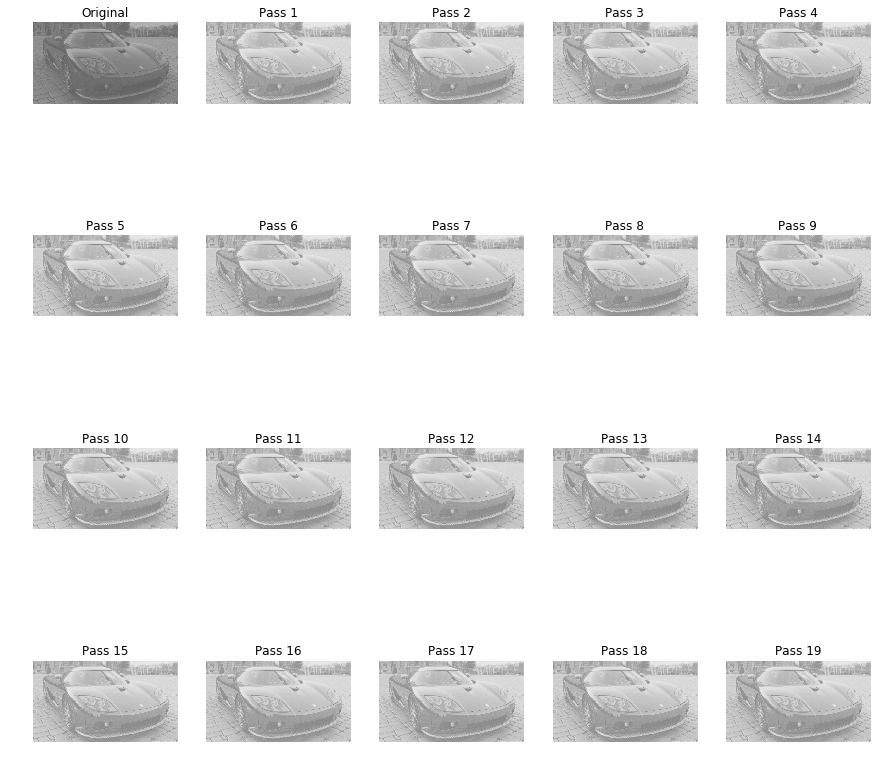

In [4]:
car = plt.imread("car.png")

histograms = [car]
titles = ["Original"]
for i in range(19):
    newcar = copy.deepcopy(car)
    newcar = im2int8(newcar)
    histograms.append(histogramEqualization(newcar,255))
    titles.append("Pass "+str(i+1))
    
displayImage(histograms,4,5,title=titles,plotsize=15)

<b>Question 5: </b>Given a 3-bit 8×8 image with its histogram shown in Table 2, perform a histogram matching using the desiredhistogram shown in Table 3.
<img src="table2and3.png">

<b>Question 6: </b>A 3-bit imageTis given below.  Perform an adaptive histogram equalization on the pixels of T (excluding theborder pixels) using a 3×3 tile.

<img src="T.png">

<h2 align="center">Lab Exercises</h1>

<b>Question 1: </b>Implement a functionimg_out = histeq_DIP(img_in) which performs histogram equalization on img_in, where img_out is the output image. Test your implementation on image ‘fractured_spine.tif’.  For this exercise,you should attempt to put the results in a very short report that includes the original image, a plot of its histogram,a plot of the histogram-equalization transformation function, the enhanced image, and a plot of its histogram. Use this information to explain why the resulting image was enhanced as it was.

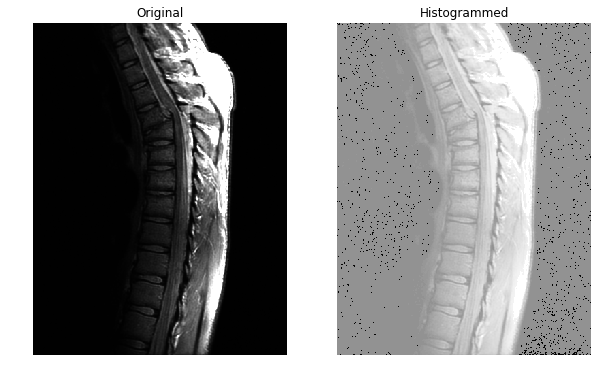

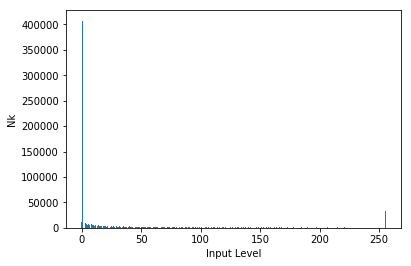

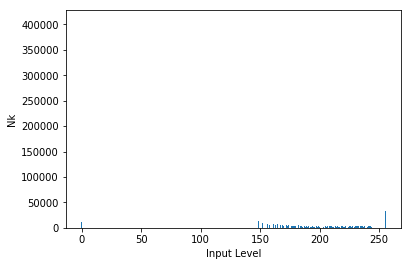

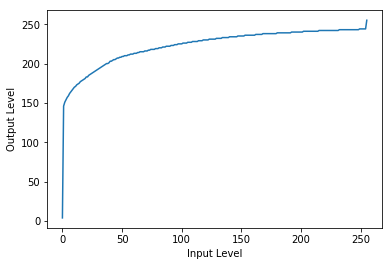

In [25]:
#Use to plot bar graph along x = [0,...,L-1]
def plotBar(histogram):
    x = np.arange(len(histogram))
    width = 1
    plt.bar(x, histogram)
    plt.xlabel('Input Level')
    plt.ylabel('Nk')
    plt.show()
    
#Use to plot line graph along x = [0,...,L-1]
def plotLine(mapping):
    x = np.arange(len(mapping))
    plt.plot(x, mapping)
    plt.xlabel('Input Level')
    plt.ylabel('Output Level')
    plt.show()

spine = plt.imread("fractured_spine.tif")
newSpine = copy.deepcopy(spine)
newSpine = histogramEqualization(newSpine,255)
displayImage([spine,newSpine],1,2,title=["Original","Histogrammed"])

histogram_spine = getHistogram(spine,255)
histogram_new = getHistogram(newSpine,255)
probs = getProbs(histogram_spine)
cdf = getCumulative(probs)
myMap = CDFToMap(cdf,255)

plotBar(histogram_spine)
plotBar(histogram_new)
plotLine(myMap)

It appears that low intensities have been boosted significantly, while high intensities have been boosted only slightly

<b>Question 2: </b>
<ol>
    <li>Implement a histogram matching functionimg_out = histogram_matching_DIP(img_in, p), where img_in is an input image, p is a specified histogram, and img_outis the output image.
    <li>Apply your implementation to image ‘aerial_washedout.png’ using the histograms of images ‘pollen_1_he.png’,and ‘mars_moon.png’.
    <li>Apply your implementation to image ‘mars_moon.png’ using the histograms of image ‘pollen_1_he.png’.
</ol>

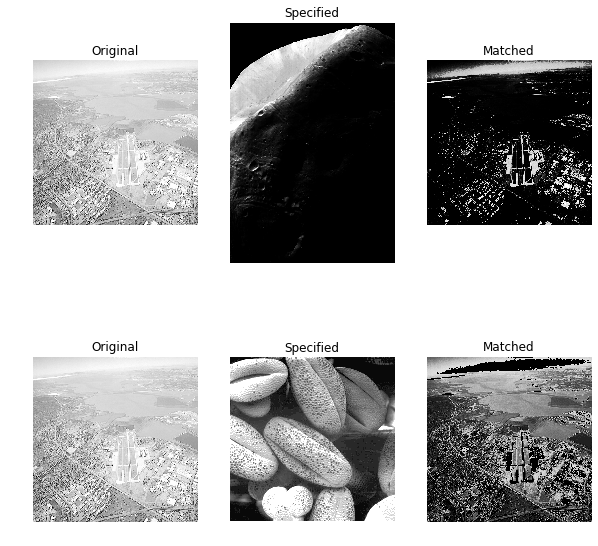

In [26]:
def histogramMatch(input_image,specified_image):
    #Copy
    image = copy.deepcopy(input_image)
    specified = copy.deepcopy(specified_image)
    #Convert images to uint8
    image = im2int8(image)
    specified = im2int8(specified)
    L = 256
    #Create r table
    hr = getHistogram(image,L)
    pr = getProbs(hr)
    cdfr = getCumulative(pr)
    sk = CDFToMap(cdfr,L)
    #Create z table
    hz = getHistogram(specified,L)
    pz = getProbs(hz)
    cdfz = getCumulative(pz)
    vk = CDFToMap(cdfz,L)
    #Find mapping
    mapping = np.zeros(L)
    for r in range(L):
        for z in range(L):
            if vk[z]-sk[r]>=0:
                mapping[r] = z
                break
    return applyMap(image,mapping)
    
    

aerial = plt.imread('aerial_washedout.png')
mars = plt.imread('mars_moon.png')
aerial_mars = histogramMatch(aerial,mars)

pollen = plt.imread('pollen_1_he.png')
aerial_pollen = histogramMatch(aerial,pollen)
displayImage([aerial,mars,aerial_mars,aerial,pollen,aerial_pollen],2,3, \
             ["Original","Specified","Matched","Original","Specified","Matched"])

<b>Question 3: </b>Implement an adaptive histogram equalization function.  To do this,  you need to divide an image into smallblocks (or tiles). Then each of these blocks are histogram equalized as usual. In adaptive histogram equalization,how would you deal with the issues caused by the following? Test your program for images ‘mars_moon.png’ and‘car.png’.
<ol>
    <li>The resulting image might have blocking effects, i.e., the borders of the tiles are clearly visible.?
    <li>Noise or outlier pixels
</ol>

In [47]:
def getTiles(image,tilesize):
    offset = math.floor(tilesize/2)
    tiles = []
    for x in range(offset,image.shape[0]-offset):
        for y in range(offset,image.shape[1]-offset):
            tile = image[x-offset:x+offset,y-offset:y+offset]
            tiles.append(tile)
    return tiles
    
mars = plt.imread("mars_moon.png")
tiles = getTiles(mars,5)
print(len(tiles))

676284


<b>Question 4: </b>Perform adaptive histogram equalization for images ‘mars_moon.png’ and ‘car.png’ using matlabadapthisteqor python scikit-image package. (See the example codeplot_equalize.py).